In [4]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass

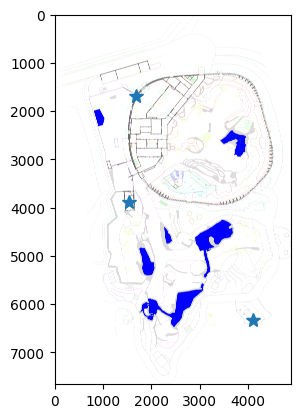

In [25]:
# Map to world constraints
@dataclass
class WorldMapConstraints:
    world2_points: np.ndarray
    map_points: np.ndarray

map_constraints= WorldMapConstraints(
    world2_points=np.array([(-73.29,55.69),(-77.21,-6.51),(-4.88,-75.34)]),
    map_points=np.array([(1682,1683),(1543,3886),(4106,6327)]))

def imread_rgb(name):
    m = cv2.imread(name)
    return cv2.cvtColor(m,cv2.COLOR_BGR2RGB)
im_map = imread_rgb("../data/kkep_floorplan.png")
plt.imshow(im_map)
plt.plot(map_constraints.map_points[:,0],map_constraints.map_points[:,1],"*",markersize=10)

In [28]:
def to_h(x):
    if len(x.shape) == 1:
        return np.concatenate([x, np.ones((1,))])
    else:
        count = x.shape[0]
        return np.concatenate([x, np.ones((count,1))],axis=1)

def from_h(x):
    if len(x.shape) == 1:
        return x[0:-1] / x[-1]
    else:
        return x[:, 0:-1] / x[:, [-1]]

def hmult(A,b):
    np.testing.assert_equal(len(A.shape),2)
    np.testing.assert_equal(A.shape[1],b.shape[-1]+1)
    bh = to_h(b)
    Abh =(A @ bh.T).T
    return from_h(Abh)

a2 = np.array([[0,0],[1,1],[2,2],[3,3]])
print(to_h(a2))
print(from_h(to_h(a2)))
A = np.eye(3)
hmult(A,np.ones((2,)))
hmult(A,np.ones((10,2)))

[[0. 0. 1.]
 [1. 1. 1.]
 [2. 2. 1.]
 [3. 3. 1.]]
[[0. 0.]
 [1. 1.]
 [2. 2.]
 [3. 3.]]


array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [29]:
# Map to world calibration
from optimization_helpers import optimizeModel,IModelEvaluator


class Similarity2DEvaluator(IModelEvaluator[np.ndarray]):
    def __init__(self, points_a: np.ndarray, points_b: np.ndarray):
        super().__init__()
        count, _ = points_a.shape
        assert points_a.shape == (count, 2)
        assert points_a.shape == points_b.shape

        self.points_a = points_a
        self.points_b = points_b

    def model2params(self, model: np.ndarray) -> np.ndarray:
        return np.array([model[0, 0], model[1, 1], model[0, 2], model[1, 2]])

    def params2model(self, params: np.ndarray) -> np.ndarray:
        return np.array([[params[0], 0, params[2]], [0, params[1], params[3]],[0,0,1]])

    def getParamBounds(self) -> None:
        return None

    def evaluateModel(self, model: np.ndarray) -> float:
        points_aa = hmult(model, self.points_b)
        cost = np.sum(np.linalg.norm(points_aa-self.points_a,axis=1))
        return cost
    
evaluator = Similarity2DEvaluator(map_constraints.map_points,map_constraints.world2_points)
m0 = np.array([[1,0,0],[0,1,0]])
display(evaluator.evaluateModel(m0))
T_map_from_world = optimizeModel(evaluator,m0,debug=True)
display("")
print(f"Final error in pixels: {evaluator.evaluateModel(T_map_from_world)}")
print(f"{T_map_from_world=}")
T_world_from_map = np.linalg.inv(T_map_from_world)
print(f"{T_world_from_map=}")


np.float64(14089.47791340048)

         Current function value: 1.512272
         Iterations: 96
         Function evaluations: 966
         Gradient evaluations: 191
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.5122718428351343
        x: [ 3.543e+01 -3.544e+01  4.279e+03  3.657e+03]
      nit: 96
      jac: [-1.424e+01  1.231e+01  1.023e+00  9.275e-01]
 hess_inv: [[ 5.132e-10 -1.240e-10  1.647e-09 -5.617e-09]
            [-1.240e-10  2.029e-10 -1.331e-09  5.206e-09]
            [ 1.647e-09 -1.331e-09  3.792e-08 -8.346e-08]
            [-5.617e-09  5.206e-09 -8.346e-08  5.318e-07]]
     nfev: 966
     njev: 191


/home/dherrera/git/zoo_vision/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


''

Final error in pixels: 1.5122718428351343
T_map_from_world=array([[ 3.54334161e+01,  0.00000000e+00,  4.27891507e+03],
       [ 0.00000000e+00, -3.54422652e+01,  3.65677974e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
T_world_from_map=array([[ 2.82219472e-02,  0.00000000e+00, -1.20759315e+02],
       [-0.00000000e+00, -2.82149009e-02,  1.03175678e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])


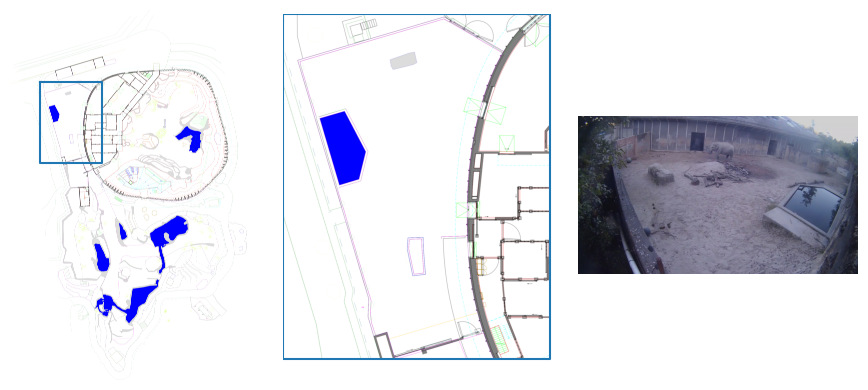

In [30]:
# Get submap for specific camera
from glob import glob
camera_name = "Kamera 01"
submap_xy = np.array([626,1500])
submap_end = np.array([1912,3164])

im_submap = im_map[submap_xy[1]:submap_end[1],submap_xy[0]:submap_end[0],:]
T_submap_from_world2 = T_map_from_world.copy()
T_submap_from_world2[0,2] -= submap_xy[0]
T_submap_from_world2[1,2] -= submap_xy[1]
T_world2_from_submap = np.linalg.inv(T_submap_from_world2)

submap_corners_in_map = np.stack([submap_xy,submap_end])
submap_corners_in_world2 = hmult(T_world_from_map, submap_corners_in_map)
submap_corners_in_submap = hmult(T_submap_from_world2,  submap_corners_in_world2)
def plot_rectangle_xyxy(ax,points):
    x0,y0 = points[0,0:2]
    x1,y1 = points[1,0:2]
    ax.plot([x0,x0,x1,x1,x0],[y0,y1,y1,y0,y0],"-")

image_filename = glob(f"../data/cameras/{camera_name}/*.jpg")[0]
im_camera = imread_rgb(image_filename)
height, width,_ = im_camera.shape

fig,axs = plt.subplots(1,3,figsize=(9,4))
axs[0].imshow(im_map)
plot_rectangle_xyxy(axs[0],submap_corners_in_map)
axs[1].imshow(im_submap)
plot_rectangle_xyxy(axs[1],submap_corners_in_submap)
axs[2].imshow(im_camera)
for ax in axs:
    ax.set_axis_off()
fig.tight_layout()

In [31]:
class MouseHandler:
    def __init__(self,img,window_name):
        self.img = img.copy()
        self.window_name = window_name
        self.positions = []

    def start(self):
        cv2.namedWindow(self.window_name)
        cv2.setMouseCallback(self.window_name,self)
        cv2.imshow(self.window_name,self.img)

    def __call__(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.positions.append((x,y))
            count = len(self.positions)
            color = [0,0,0]
            color[count%3] = 200
            self.img = cv2.circle(self.img, (x,y),radius=10, color=color, thickness=5)
            cv2.imshow(self.window_name,self.img)

submapClicker=MouseHandler(im_submap, "submap")
cameraClicker = MouseHandler(im_camera, f"camera: {camera_name}")

submapClicker.positions=[(962, 424), (942, 494), (890, 911), (517, 222), (624, 1261), (1057, 190)]
cameraClicker.positions=[(769, 242), (860, 249), (1295, 277), (571, 471), (1709, 384), (497, 234)]
if len(submapClicker.positions)== 0 or len(cameraClicker.positions)==0:
    cv2.startWindowThread()
    submapClicker.start()
    cameraClicker.start()

    key = cv2.waitKey(0)
    cv2.destroyAllWindows()

print(submapClicker.positions)
print(cameraClicker.positions)

[(962, 424), (942, 494), (890, 911), (517, 222), (624, 1261), (1057, 190)]
[(769, 242), (860, 249), (1295, 277), (571, 471), (1709, 384), (497, 234)]


In [73]:
@dataclass
class CameraConstraints:
    camera_points: np.ndarray
    world_points: np.ndarray

submap_points = np.array(submapClicker.positions)
world2_points = hmult(T_world2_from_submap, submap_points)

world_points = np.zeros((world2_points.shape[0],3))
world_points[:,0:2] = world2_points

camera_constraints = CameraConstraints( camera_points = np.array(cameraClicker.positions), world_points=world_points)
print(camera_constraints)

H_world2_from_camera,inliers=cv2.findHomography(camera_constraints.camera_points, camera_constraints.world_points[:,0:2])
print(f"Inliners {inliers.sum()/len(inliers):.0%}")
print(f"H_world2_from_camera=\n{H_world2_from_camera}")
H_camera_from_world2 = np.linalg.inv(H_world2_from_camera)

H_submap_from_camera = T_submap_from_world2 @ H_world2_from_camera
H_camera_from_submap = np.linalg.inv(H_submap_from_camera)
print(f"H_submap_from_camera=\n{H_submap_from_camera}")

errors = np.mean(np.linalg.norm(submap_points - hmult(H_submap_from_camera, camera_constraints.camera_points), axis=1))
print("Mean error (submap units): ", errors)

errors = np.mean(np.linalg.norm(world2_points  - hmult(H_world2_from_camera, camera_constraints.camera_points), axis=1))
print("Mean error (world units): ", errors)

errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_camera_from_world2, camera_constraints.world_points[:,0:2]), axis=1))
print("Mean error (camera units): ", errors)


CameraConstraints(camera_points=array([[ 769,  242],
       [ 860,  249],
       [1295,  277],
       [ 571,  471],
       [1709,  384],
       [ 497,  234]]), world_points=array([[-75.94286309,  48.89020869,   0.        ],
       [-76.50730203,  46.91516562,   0.        ],
       [-77.97484329,  35.14955195,   0.        ],
       [-88.5016296 ,  54.58961867,   0.        ],
       [-85.48188124,  25.27433663,   0.        ],
       [-73.2617781 ,  55.4924955 ,   0.        ]]))
Inliners 100%
H_world2_from_camera=
[[-4.34370289e-03 -4.98102927e-02 -5.95088751e+01]
 [-2.42513229e-02 -2.66830418e-03  6.78468429e+01]
 [ 2.72435452e-05 -1.05117713e-04  1.00000000e+00]]
H_submap_from_camera=
[[-5.43938753e-02 -2.14893491e+00  1.54431234e+03]
 [ 9.18280144e-01 -1.32145010e-01 -2.47866056e+02]
 [ 2.72435452e-05 -1.05117713e-04  1.00000000e+00]]
Mean error (submap units):  18.542967743543446
Mean error (world units):  0.5232931223332512
Mean error (camera units):  11.725872413780428


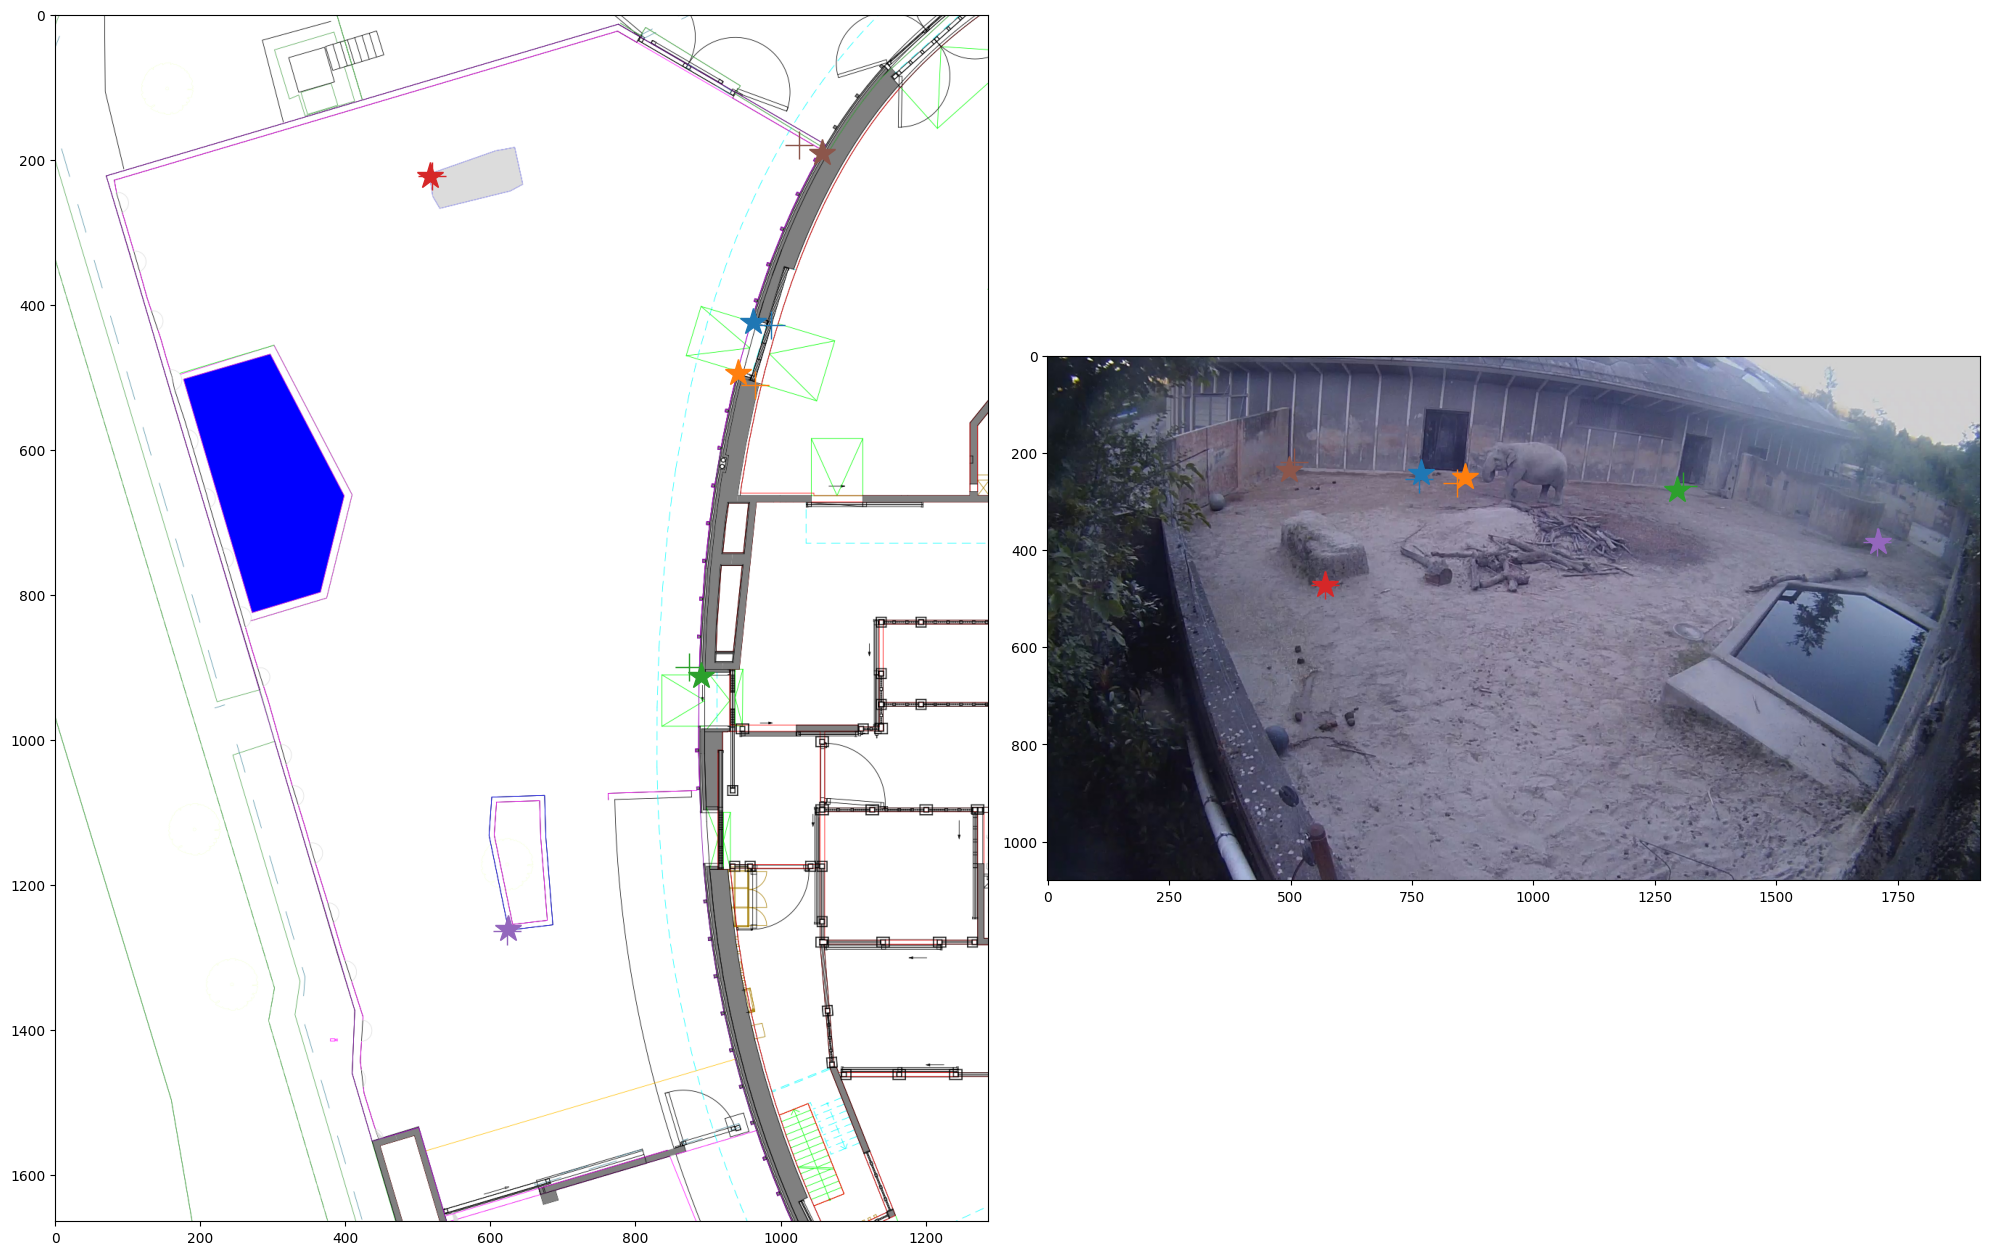

In [114]:
def plot_projections(H_camera_from_world2):
    H_camera_from_submap_exp = H_camera_from_world2 @ T_world2_from_submap
    H_submap_from_camera_exp = np.linalg.inv(H_camera_from_submap_exp)

    fig,axs = plt.subplots(1,2,figsize=(20,15))
    axs[0].imshow(im_submap)
    axs[1].imshow(im_camera)
    for i in range(camera_constraints.camera_points.shape[0]):
        cp = camera_constraints.camera_points[i]
        sp = hmult(T_submap_from_world2, camera_constraints.world_points[i,0:2])
        cp2 =hmult( H_camera_from_submap_exp,sp)
        sp2 =hmult( H_submap_from_camera_exp,cp)
        c = f"C{i}"
        axs[0].plot(sp[0],sp[1],"*",markersize=20, color=c)
        axs[0].plot(sp2[0],sp2[1],"+",markersize=20, color=c)
        axs[1].plot(cp[0],cp[1],"*",markersize=20, color=c)
        axs[1].plot(cp2[0],cp2[1],"+",markersize=20, color=c)
    fig.tight_layout()
plot_projections(H_camera_from_world2)

[1030.71067812  469.28932188]
[ 1. -1. -1.]


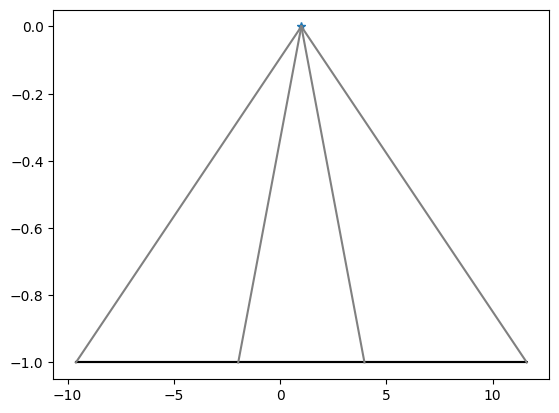

In [90]:
import scipy.spatial
from dataclasses import dataclass

def undistort_points(r_distortion:float,center:np.ndarray,points:np.ndarray)->np.ndarray:
    np.testing.assert_equal(points.shape[-1],2)
    assert center.shape in [(2,),(1,2)]

    points_c = points-center
    points_dist = points_c / r_distortion + center
    
    return points_dist

    
def distort_points(r_distortion:float,center:np.ndarray,points:np.ndarray)->np.ndarray:
    np.testing.assert_equal(points.shape[-1],2)
    assert center.shape in [(2,),(1,2)]

    points_c = points-center
    points_dist = (points_c * r_distortion) + center
    
    return points_dist

# center=np.array([5,5])
# test_points = np.array([(10,10),(0,0),(10,0)]).T
# test_points_d = distort_points(1.5,center,test_points)
# display(test_points_d)
# display(undistort_points(1.5,center,test_points_d))

@dataclass
class KRt:
    width: int
    height: int
    r_distortion: float
    K: np.ndarray
    R_world_from_camera: np.ndarray
    t_in_world: np.ndarray

    def __repr__(self):
        return f"r_dist={self.r_distortion}\nK=\n{self.K}\nR_world_from_camera=\n{self.R_world_from_camera}\nt_in_world={self.t_in_world.T}"

    def get_center_in_world(self) -> np.ndarray:
        return self.t_in_world

    def project_points(self, points_in_world: np.ndarray) -> np.ndarray:
        R_camera_from_world=self.R_world_from_camera.T
        points_in_camera = (R_camera_from_world @ (points_in_world - self.t_in_world).T).T
        points_in_camera_norm = (self.K @ points_in_camera.T).T
        points_in_image_undist = from_h(points_in_camera_norm)
        points_in_image = distort_points(
            self.r_distortion, self.K[0:2, 2], points_in_image_undist
        )
        return points_in_image

    def unproject_points(self, points_in_image: np.ndarray, depth=1) -> np.ndarray:
        invK = np.linalg.inv(self.K)

        points_in_image_undist = undistort_points(
            self.r_distortion, self.K[0:2, 2], points_in_image
        )
        camera_points_norm = (invK @ to_h(points_in_image_undist).T).T
        world_points = (
            self.R_world_from_camera @ camera_points_norm.T
        ).T * depth + self.t_in_world
        return world_points


def plot_camera(ax, model: KRt, scale=1, T_image_from_world: np.ndarray | None=None):
    center = model.get_center_in_world().squeeze()
    h, w = model.height, model.width
    p = np.array([[0, 0], [0, h], [w, h], [w, 0]])
    xyz = model.unproject_points(p, scale)

    # Drop z
    xy = xyz[:,0:2]

    if T_image_from_world is not None:
        xy = hmult(T_image_from_world, xy)

    x = xy[:,0]
    y = xy[:,1]
    ax.plot([center[0]], [center[1]], "*")
    ax.plot(
        [x[0], x[1], x[2], x[3], x[0]],
        [y[0], y[1], y[2], y[3], y[0]],
        "-",
        color="black",
    )
    for i in range(4):
        ax.plot([center[0], x[i]], [center[1], y[i]], "-", color="gray")


R = scipy.spatial.transform.Rotation.from_euler(
    seq="xyz", angles=[np.pi / 2, np.pi / 4, 0]
).as_matrix()
# print(R)
dummy_model = KRt(
    width=width,
    height=height,
    r_distortion=1,
    K=np.array([[100,0,width/2],[0,100,height/2],[0,0,1]]),
    R_world_from_camera=R,
    t_in_world=np.array([1, 0, 0]),
)
_, ax = plt.subplots(1, 1)
p = np.array([1,-1,-1])
x=dummy_model.project_points(p)
print(x)
pp = dummy_model.unproject_points(x)
print(pp)
plot_camera(ax, dummy_model, scale=1)

In [122]:
def make_H(K: np.ndarray, R: np.ndarray, t: np.ndarray):
    Rt = np.concatenate([R[:,[0,1]],t.reshape((3,1))],axis=1)
    Hp = K @ Rt
    return Hp

def make_H_camera_from_world2(camera: KRt):
    R_camera_from_world = camera.R_world_from_camera.T
    t_in_camera = -R_camera_from_world @ camera.t_in_world
    return make_H(camera.K, R_camera_from_world, t_in_camera)

make_H_camera_from_world2(dummy_model)

array([[ 7.07106781e+01, -9.60000000e+02, -7.07106781e+01],
       [ 7.07106781e+01, -5.40000000e+02, -7.07106781e+01],
       [ 1.11022302e-16, -1.00000000e+00, -1.11022302e-16]])

In [152]:
# Decompose homography into K*[R|t]
# Construct a default K matrix
fov = 170 * np.pi / 180 # Assume our cameras have a wide fov
fx = width / np.tan(fov/2)
# print(f"H=\n{H_camera_from_world2}")

K0 = np.array([[fx,0,width/2],[0,fx,height/2],[0,0,1]])
invK0 = np.linalg.inv(K0)
# print(f"{K0=}")

Rt = invK0 @ H_camera_from_world2
# print(f"Rt=\n{Rt}")

factor = np.mean([np.linalg.norm(Rt[:,0]),np.linalg.norm(Rt[:,1])])
Rt /= factor
r1 = Rt[:,0]
r2 = Rt[:,1]
r3 = np.cross(r1,r2)
R = np.stack([r1,r2,r3]).T
# print(r1)
t = Rt[:,2]
print("First R approximation")
print(f"R=\n{R}")
print(f"Det={np.linalg.det(R)}")

# W,U,Vt=cv2.SVDecomp(R)
# R = U@Vt
# print("Second R approximation")
# print(R)
# print(f"Det={np.linalg.det(R)}")

H_exp = make_H(K0,R,t)
errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
print("Mean H direct error (camera units): ", errors)

camera_in_world = KRt(width=width,height=height,r_distortion=1,K=K0,R_world_from_camera=R.T,t_in_world=-R.T@t)
print(camera_in_world)
# T_camera_from_world = np.concatenate([R,t[:,None]],axis=1)
# T_camera_from_world = np.concatenate([T_camera_from_world, [[0,0,0,1]]],axis=0)
# T_world_from_camera = np.linalg.inv(T_camera_from_world)
# print(f"T_camera_from_world=\n{T_camera_from_world}")
# print(f"T_world_from_camera=\n{T_world_from_camera}")

def homography_error(Ha,Hb):
    sHa = np.linalg.norm(Ha.reshape((-1)))
    sHb = np.linalg.norm(Hb.reshape((-1)))
    Ha = Ha *sHb/sHa
    cost = np.linalg.norm((Hb - Ha).reshape(-1))
    return cost

def test_camera(camera_in_world: KRt):
    H_camera_from_world2_exp = make_H_camera_from_world2(camera_in_world)
    error = (homography_error(H_camera_from_world2_exp, H_camera_from_world2))
    print(f"Homography camera_from_world2 error: {error}")
    # H_camera_from_world2 = np.linalg.inv(H_camera_from_world2)

    camera_points_exp = hmult(H_camera_from_world2_exp, camera_constraints.world_points[:,0:2])
    # camera_points_exp = camera_in_world.project_points(camera_constraints.world_points)
    # print(camera_points_exp.shape)
    # world_points_exp = camera_in_world.project_points(camera_constraints.world_points)
    
    # # errors = np.mean(np.linalg.norm(world_points_exp  - camera_constraints.world_points, axis=1))
    # # print("Mean error (world units): ", errors)

    # errors = np.mean(np.linalg.norm(camera_points_exp  - camera_constraints.camera_points, axis=1))
    # print("Mean error (camera units): ", errors)
    errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_camera_from_world2_exp, camera_constraints.world_points[:,0:2]), axis=1))
    print("Mean error (camera units): ", errors)
    # print(camera_points_exp)



test_camera(camera_in_world)
# plot_projections(H_exp)

First R approximation
R=
[[-0.04713271 -1.3997093  -0.00395876]
 [-0.59768468  0.0422072   0.01527467]
 [-0.01066435  0.00737659 -0.83857415]]
Det=0.7034555849271493
Mean H direct error (camera units):  11.725872413780332
r_dist=1
K=
[[167.97823397   0.         960.        ]
 [  0.         167.97823397 540.        ]
 [  0.           0.           1.        ]]
R_world_from_camera=
[[-0.04713271 -0.59768468 -0.01066435]
 [-1.3997093   0.0422072   0.00737659]
 [-0.00395876  0.01527467 -0.83857415]]
t_in_world=[-31.72107674  83.3933911    5.19134274]
Homography camera_from_world2 error: 984.1456349218789
Mean error (camera units):  2433.2784099615906


Cost at start: 154.4949065384058
Final cost: 50.41251987581144
h_model=RtModel(K=array([[163.12929606,   0.        , 950.95980315],
       [  0.        ,  73.80628797, 513.39454455],
       [  0.        ,   0.        ,   1.        ]]), R=array([[-0.14365929, -0.99666052],
       [-0.98993569,  0.08758933],
       [ 0.03700384, -0.02059503]]), t=array([ 33.19303851, -94.48812784,   8.04868694]))
Mean H direct error (camera units):  11.725872413780332
Mean H direct error (camera units):  7.445203583099425
R norm errors:  [0.00098948 0.00071387 0.05570964]


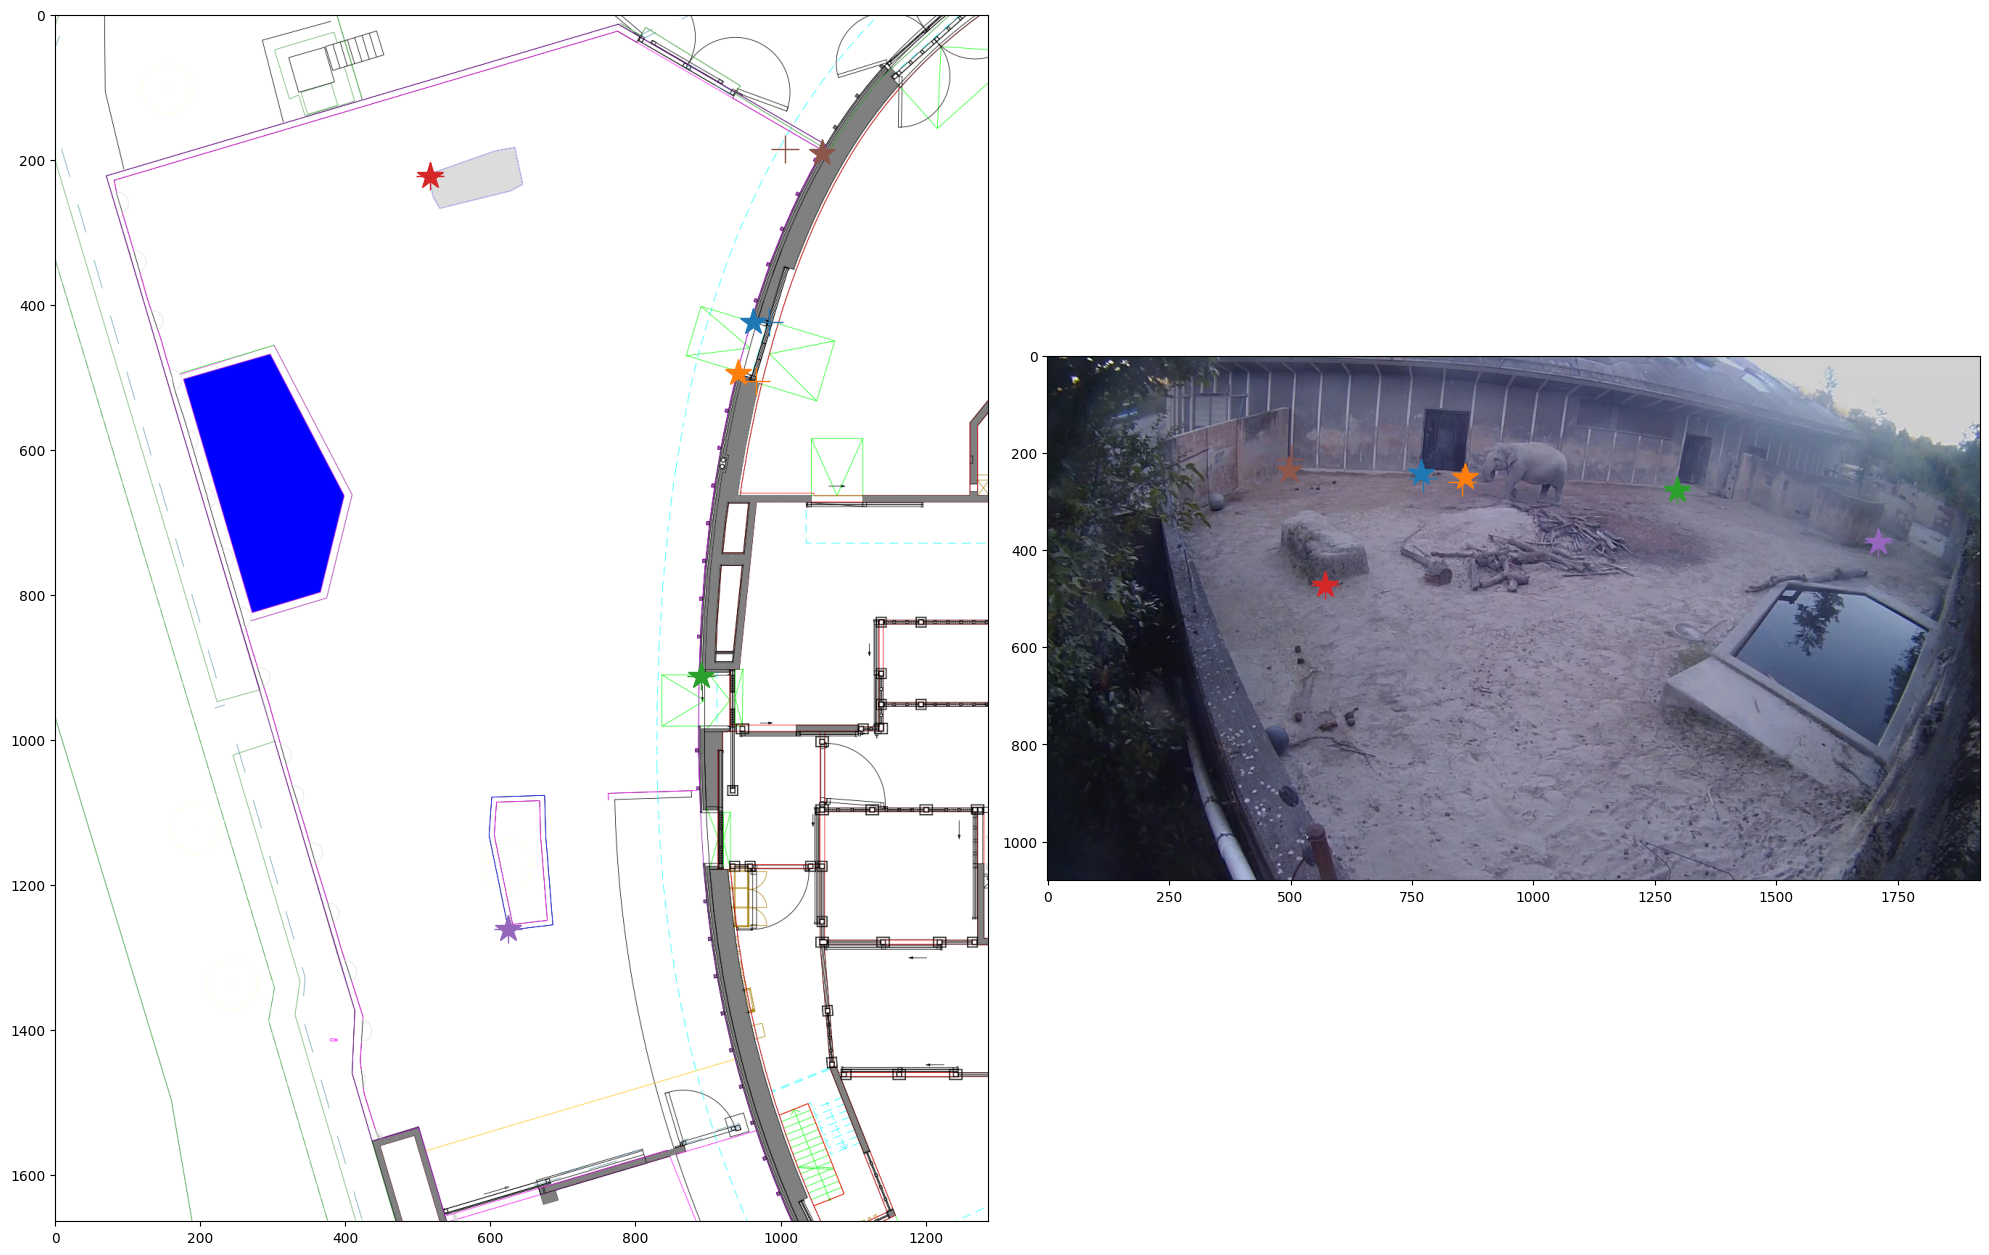

In [153]:
import scipy.optimize
from optimization_helpers import optimizeModel,IModelEvaluator
from dataclasses import dataclass
import scipy

@dataclass 
class RtModel:
    K: np.ndarray
    R: np.ndarray
    t: np.ndarray

    def make_H(self):
        return make_H(self.K,self.R,self.t)

class RtEvaluator(IModelEvaluator[RtModel]):
    def __init__(self, model0: RtModel):
        super().__init__()
        self.model0 = model0

    def model2params(self, model: RtModel) -> np.ndarray:
        fx = model.K[0,0]
        alpha = model.K[1,1]/fx
        cx = model.K[0,2]
        cy = model.K[1,2]
        r1x,r1y,r1z = model.R[:,0]
        r2x,r2y,r2z = model.R[:,1]
        tx,ty,tz = model.t.reshape((3,))
        params_list = [fx,alpha,cx,cy,r1x,r1y,r1z,r2x,r2y,r2z,tx,ty,tz]
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> RtModel:
        fx,alpha,cx,cy,r1x,r1y,r1z,r2x,r2y,r2z,tx,ty,tz= params
        K = np.array([[fx,0,cx],[0,fx*alpha,cy],[0,0,1]])
        R = np.array([[r1x,r1y,r1z],[r2x,r2y,r2z,]]).T
        t = np.array([tx,ty,tz])
        model = RtModel(
                    K=K,
                    R=R,
                    t=t)
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds|None:
        return None

    def get_norm_errors(self,model:RtModel)->np.ndarray:
        r1 = model.R[:,0]
        r2 = model.R[:,1]
        error_norm1 = np.abs((1-np.linalg.norm(r1)))
        error_norm2 = np.abs((1-np.linalg.norm(r2)))
        error_prod = np.abs(np.dot(r1,r2))
        return np.array([error_norm1,error_norm2,error_prod])

    def evaluateModel(self, model: RtModel) -> float:
        H_exp = model.make_H()

        errors = np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1)

        return np.sum(errors) + 100*np.sum(self.get_norm_errors(model))

h_model0 = RtModel(K=K0,R=R,t=t)
evaluator = RtEvaluator(model0=h_model0)
print(f"Cost at start: {evaluator.evaluateModel(h_model0)}")
h_model= optimizeModel(evaluator,h_model0)

print(f"Final cost: {evaluator.evaluateModel(h_model)}")
print(f"{h_model=}")

H_exp = h_model0.make_H()
errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
print("Mean H direct error (camera units): ", errors)

H_exp = h_model.make_H()
errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
print("Mean H direct error (camera units): ", errors)

print("R norm errors: ", evaluator.get_norm_errors(h_model))

plot_projections(H_exp)

Homography camera_from_world2 error: 646.2140315556505
Mean error (camera units):  102.17780838199407


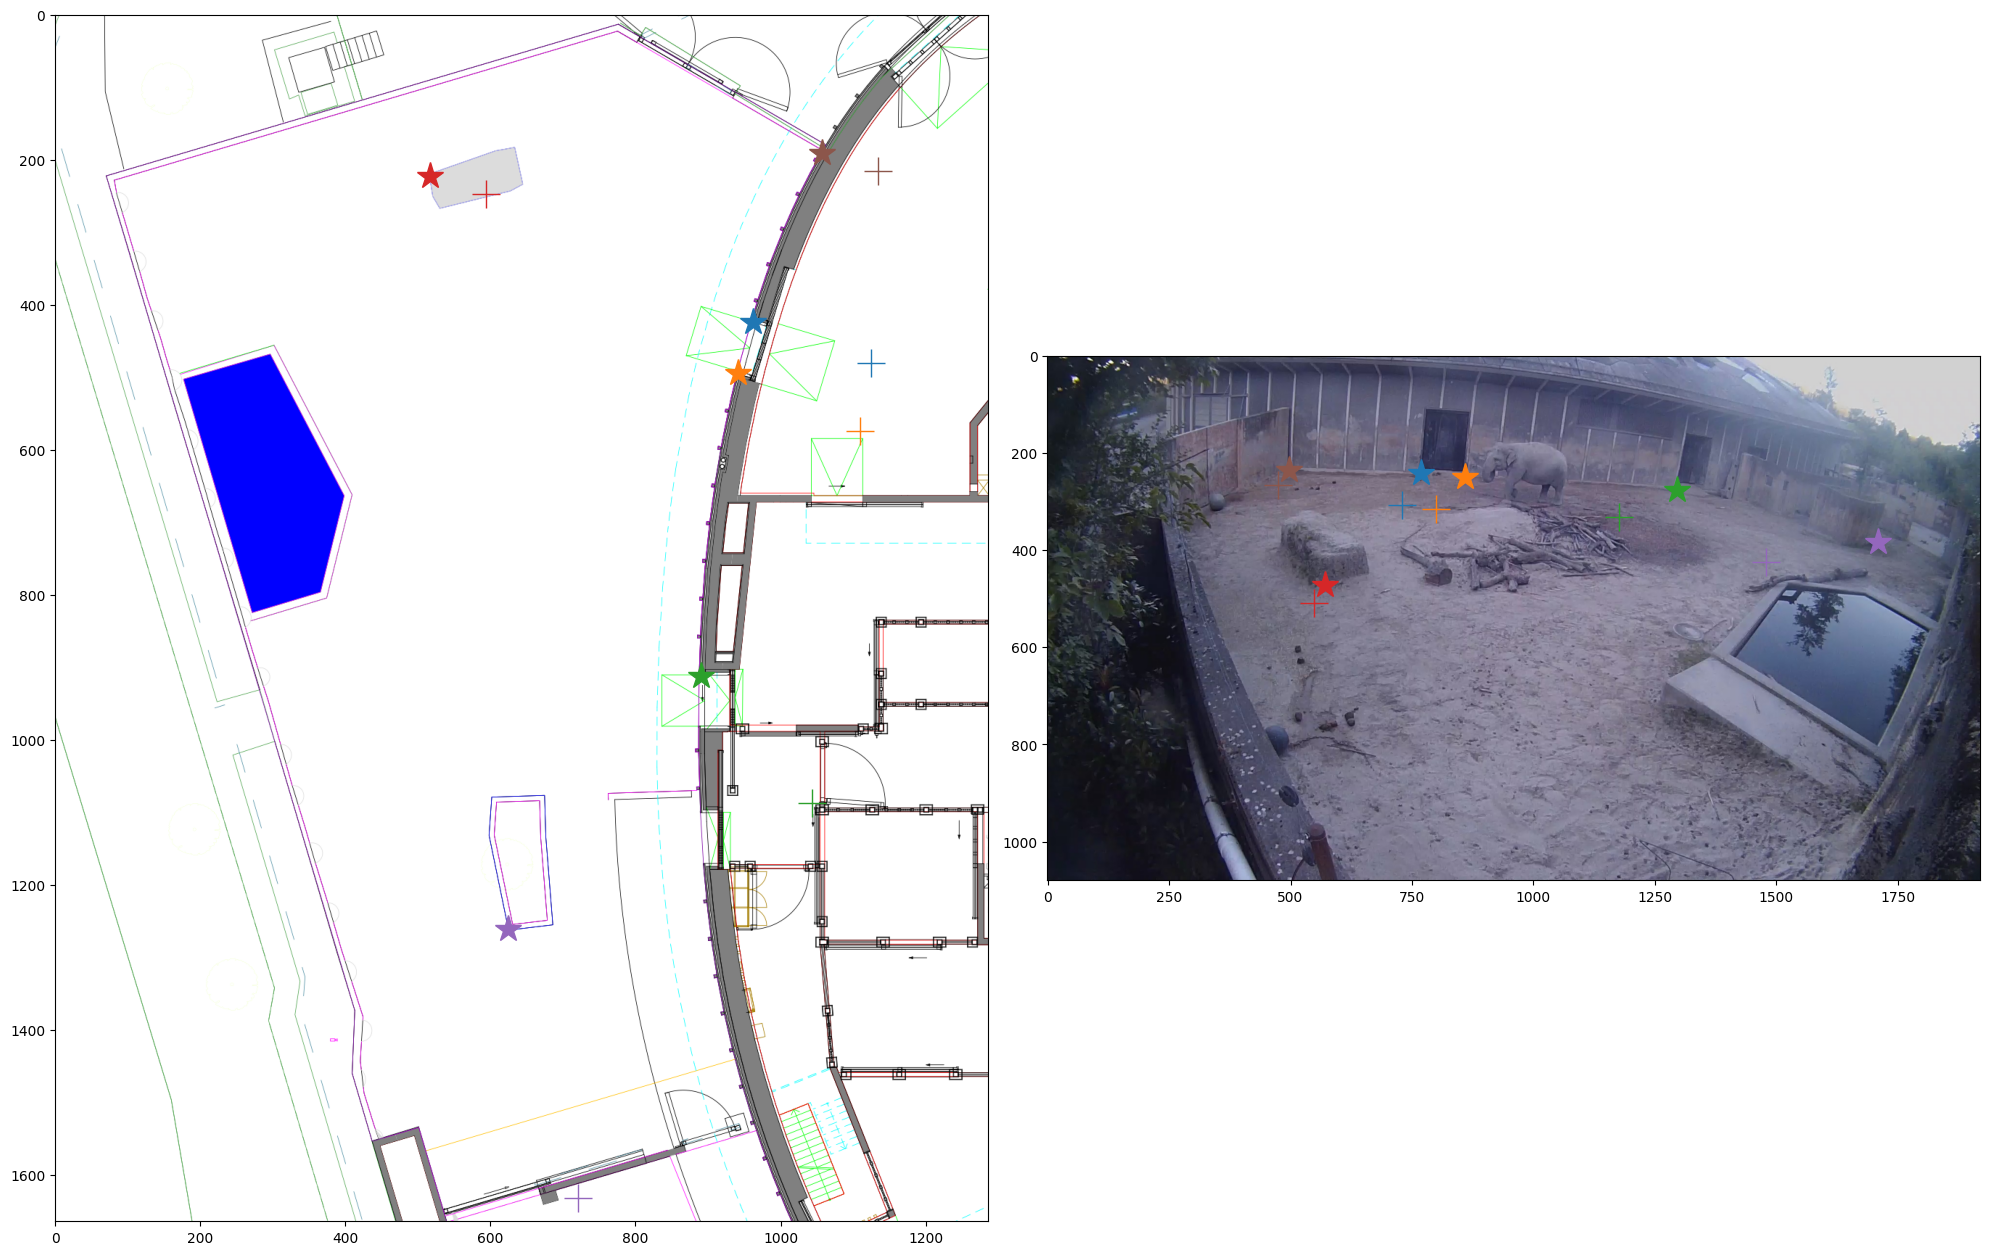

In [160]:
def R_from_R2(R2):
    R2 = h_model.R
    r1 = R2[:,0]
    r2 = R2[:,1]
    r3 = np.cross(r1,r2)
    R0 = np.stack([r1,r2,r3])
    W,U,Vt=cv2.SVDecomp(R0)
    Rfix = U@Vt
    return Rfix

def camera_from_rtmodel(rtmodel:RtModel):
    K = rtmodel.K
    R = R_from_R2(rtmodel.R)
    t = rtmodel.t
    return KRt(width=width,height=height,r_distortion=1,K=K,R_world_from_camera=R.T,t_in_world=-R.T@t)
    # return KRt(width=width,height=height,r_distortion=1,K=K,R_world_from_camera=R,t_in_world=t)

# H_exp = make_H(h_model.K, Rfix, h_model.t)
# errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
# print("Mean H direct error (camera units): ", errors)
# plot_projections(H_exp)
camera_from_decomposition = camera_from_rtmodel(h_model)
test_camera(camera_from_decomposition)
plot_projections(make_H_camera_from_world2(camera_from_decomposition))


In [ ]:
# import scipy.optimize
# from optimization_helpers import optimizeModel,IModelEvaluator
# from dataclasses import dataclass
# import scipy

# class HomographyEvaluator(IModelEvaluator[KRt]):
#     def __init__(self, homography: np.ndarray, model0: KRt):
#         super().__init__()
#         assert homography.shape == (3,3)
#         self.homography = homography
#         self.model0 = model0

#     def model2params(self, model: KRt) -> np.ndarray:
#         rp,_ = cv2.Rodrigues(model.R_world_from_camera)
#         rp=rp.reshape((-1))
#         tx,ty,tz = model.t_in_world.reshape((3,))
#         # params= np.array([model.K[0,0],model.K[1,1],rp[0],rp[1],rp[2],model.t[0],model.t[1],model.t[2]])
#         params_list = [rp[0],rp[1],rp[2],tx,ty,tz]
#         return np.array(params_list)

#     def params2model(self, params: np.ndarray) -> KRt:
#         rx, ry, rz, tx, ty, tz = params
#         R,_=cv2.Rodrigues(np.array([rx,ry,rz]))
#         model = KRt(
#                     width=width,
#                     height=height,
#                     r_distortion=1,
#                     K=self.model0.K,
#                     R_world_from_camera=R,
#                     t_in_world=np.array([tx,ty,tz]).reshape((3,)))
#         return model

#     def getParamBounds(self) -> scipy.optimize.Bounds|None:
#         return None

#     def evaluateModel(self, model: KRt) -> float:
#         Hp = make_H_camera_from_world2(model)

#         sHp = np.linalg.norm(Hp.reshape((-1)))
#         sH = np.linalg.norm(self.homography.reshape((-1)))
#         Hp = Hp *sH/sHp
#         cost = np.linalg.norm((self.homography - Hp).reshape(-1))
#         return cost

# h_model0 = camera_in_world
# evaluator = HomographyEvaluator(homography=H_camera_from_world2,model0=h_model0)
# display(evaluator.evaluateModel(h_model0))
# h_model= optimizeModel(evaluator,h_model0,debug=True)


# display("")
# print(f"Final error: {evaluator.evaluateModel(h_model)}")
# print(f"{h_model=}")
# Hp = make_H_camera_from_world2(h_model)
# print(f"{H_camera_from_world2=}")
# print(f"{Hp=}")

# print(f"{h_model=}")

# test_camera(h_model)


np.float64(21.783483392449448)

         Current function value: 0.021193
         Iterations: 105
         Function evaluations: 1209
         Gradient evaluations: 171
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.021192871714051868
        x: [ 1.652e+00 -2.651e+00  1.958e-01 -2.968e+01  8.745e+01
            -6.027e+00]
      nit: 105
      jac: [-7.200e+00  4.090e+01  8.859e+01  2.019e-01  1.769e-01
             1.574e+00]
 hess_inv: [[ 8.961e-05  5.597e-05 ... -3.401e-03  1.104e-03]
            [ 5.597e-05  3.722e-05 ... -2.702e-03  8.537e-04]
            ...
            [-3.401e-03 -2.702e-03 ...  1.565e+01 -4.766e+00]
            [ 1.104e-03  8.537e-04 ... -4.766e+00  1.462e+00]]
     nfev: 1209
     njev: 171


/home/dherrera/git/zoo_vision/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


''

Final error: 0.021192871714051868
h_model=r_dist=1
K=
[[167.97823397   0.         960.        ]
 [  0.         167.97823397 540.        ]
 [  0.           0.           1.        ]]
R_world_from_camera=
[[-0.44291649 -0.89480439  0.05612568]
 [-0.89334286  0.43515932 -0.11213791]
 [ 0.07591788 -0.09980721 -0.99210634]]
t_in_world=[-29.68408558  87.45033707  -6.02680291]
H_camera_from_world2=array([[-3.02524424e+00, -3.79990356e+01,  2.39808571e+03],
       [-1.76893063e+01,  1.84517782e+00, -1.17786021e+03],
       [-1.77704105e-03,  1.22918932e-03,  8.10853672e-01]])
Hp=array([[-2.05196743e+01, -2.57714545e+02,  1.62649129e+04],
       [-1.19999792e+02,  1.25428246e+01, -7.98878419e+03],
       [ 5.61256832e-02, -1.12137906e-01,  5.49330786e+00]])
h_model=r_dist=1
K=
[[167.97823397   0.         960.        ]
 [  0.         167.97823397 540.        ]
 [  0.           0.           1.        ]]
R_world_from_camera=
[[-0.44291649 -0.89480439  0.05612568]
 [-0.89334286  0.43515932 -0.112137

Final errors: [[-8.22568531e-01 -9.97646425e-03  0.00000000e+00 -3.01559207e+00
  -1.25892808e+01]
 [-7.98771264e-01  2.92991418e-01  0.00000000e+00  8.49892261e+00
  -1.24738000e+01]
 [ 2.64208453e-01 -2.20623836e-01  0.00000000e+00 -6.45913331e+00
   4.15888540e+00]
 [-6.91795454e-02  4.62300397e-02  0.00000000e+00  1.88069822e+00
  -1.34324351e+00]
 [ 4.78903771e-01 -4.57383282e-02  0.00000000e+00  2.28292339e+00
   7.54290744e+00]
 [ 9.69188600e-01 -1.25576238e-01  0.00000000e+00 -3.47251700e+00
   1.50301938e+01]]
model=r_dist=1.2441475295403412
K=
[[163.13077865   0.         951.00749075]
 [  0.          70.5993529  513.30573302]
 [  0.           0.           1.        ]]
R_world_from_camera=
[[-0.10720956 -0.99382438  0.02862173]
 [-0.99412257  0.10671715 -0.01821457]
 [ 0.01504765 -0.03040628 -0.99942435]]
t_in_world=[-91.78305507  46.06437993   4.79363086]
camera_center_in_world=array([-91.78305507,  46.06437993,   4.79363086])


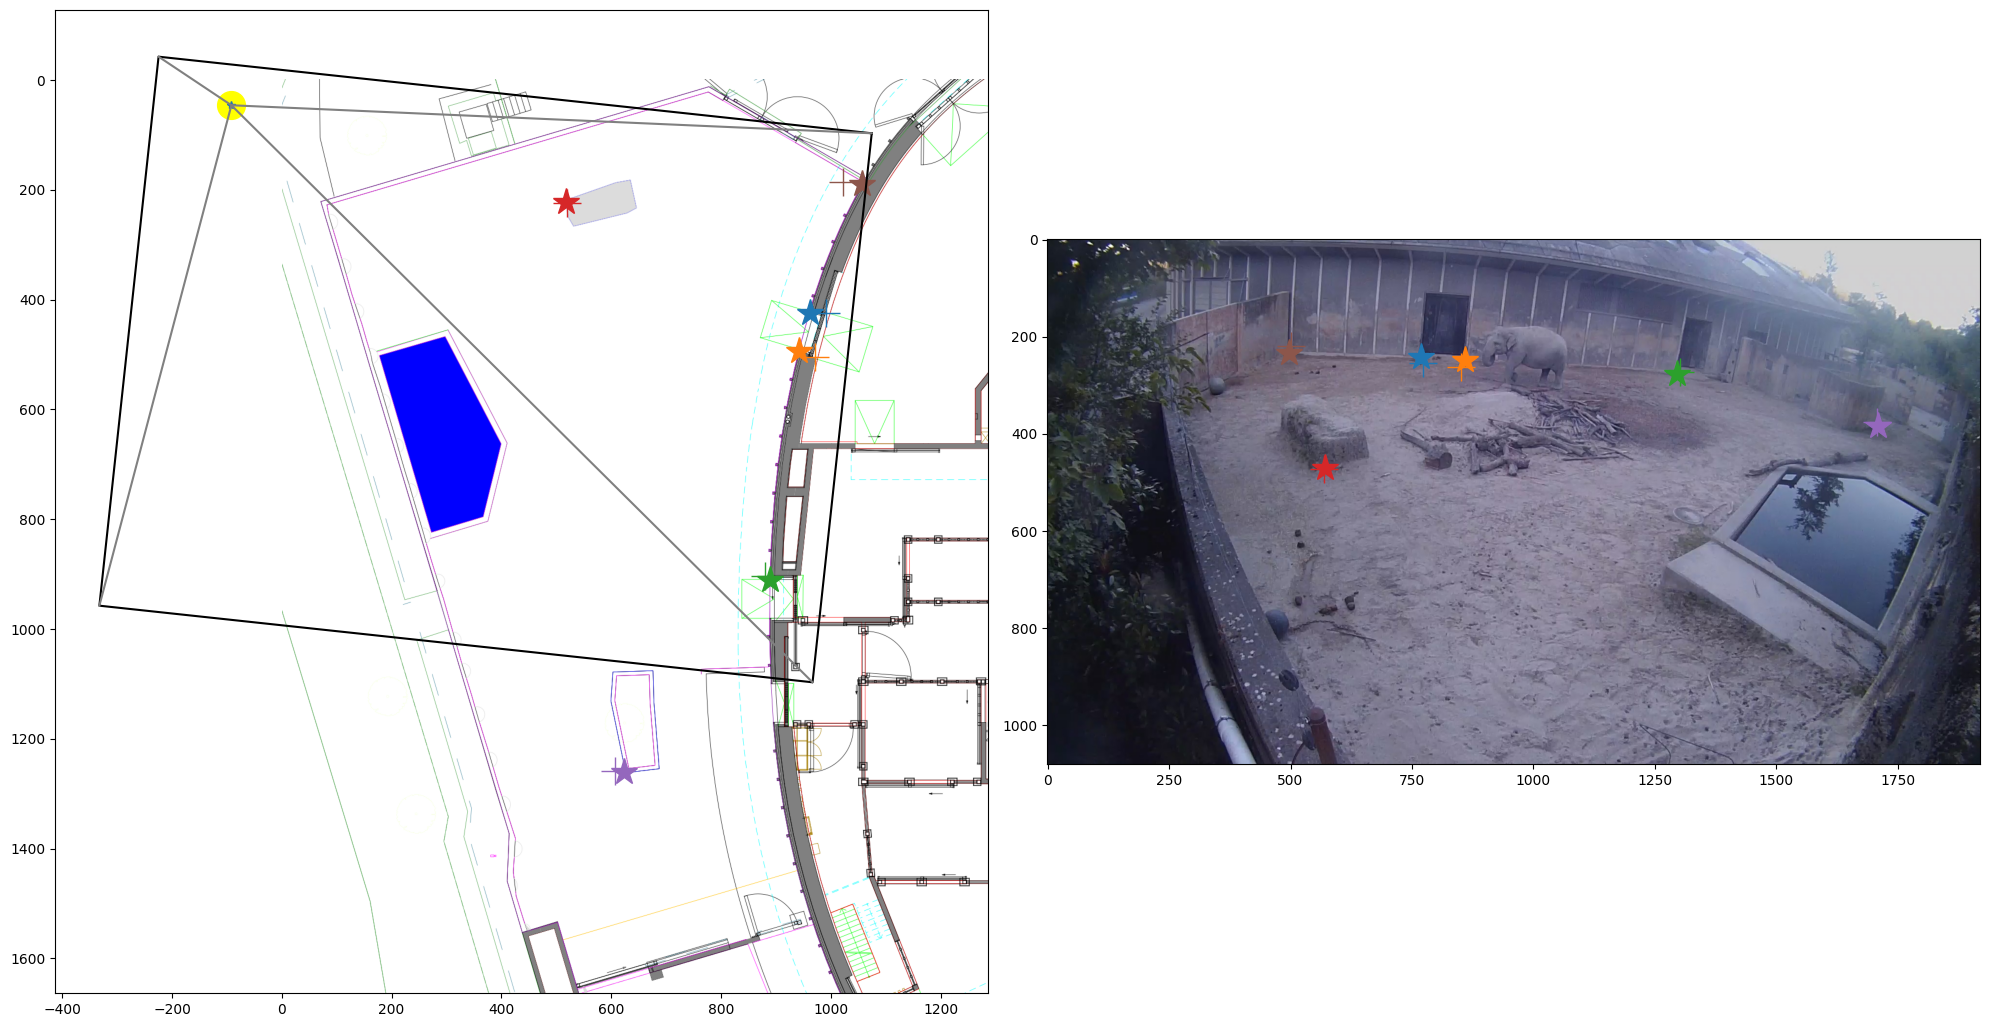

In [174]:
class ProjectionEvaluator(IModelEvaluator[KRt]):
    def __init__(
        self, camera_points: np.ndarray, world_points: np.ndarray, model0: KRt
    ):
        super().__init__()
        self.world_points = world_points
        self.camera_points = camera_points
        self.model0 = model0

    def model2params(self, model: KRt) -> np.ndarray:
        rp, _ = cv2.Rodrigues(model.R_world_from_camera)
        rx, ry, rz = rp.reshape((3,))
        tx, ty, tz = model.t_in_world.reshape((3,))

        fx = model.K[0, 0]
        alpha = model.K[1, 1] / model.K[0, 0]
        cx = model.K[0,2]
        cy = model.K[1,2]

        params_list = [model.r_distortion, fx, alpha,cx,cy, rx, ry, rz, tx, ty, tz]
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> KRt:
        r_distortion, fx, alpha,cx,cy, rx, ry, rz, tx, ty, tz = params

        R, _ = cv2.Rodrigues(np.array([rx, ry, rz]))
        t = np.array([tx, ty, tz])

        K = np.array([[fx,0,cx],[0,fx*alpha,cy],[0,0,1]])

        # fx = self.model0.K[0,0]
        # alpha=1
        # r_distortion=1
        # t[2, 0] = 3

        model = KRt(
            width=self.model0.width,
            height=self.model0.height,
            r_distortion=r_distortion,
            K=K,
            R_world_from_camera=R,
            t_in_world=t,
        )
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds:
        lb = np.full((11,), -np.inf)
        lb[0] = 0.1
        lb[1] = 0.1
        lb[2] = 0.1
        return scipy.optimize.Bounds(lb=lb)

    def compute_world_points(self, model: KRt,debug=False) -> np.ndarray:
        center = model.get_center_in_world()

        world_points_d1 = model.unproject_points(self.camera_points)
        x_dir = world_points_d1 - center

        depth = -center[2] / x_dir[:,2]
        world_points_exp = center + x_dir*depth[:,None]

        if debug:
            print(f"{self.camera_points=}\n{world_points_d1=}\n{x_dir=}\n{depth=}\n{world_points_exp=}")
        return world_points_exp

    def compute_errors(self, model: KRt,debug=False) -> np.ndarray:
        world_points_exp = self.compute_world_points(model,debug)
        errors_world = self.world_points - world_points_exp

        camera_points_exp = model.project_points(self.world_points)
        errors_camera = self.camera_points - camera_points_exp
        
        return np.concatenate([errors_world,errors_camera],axis=1)

    def evaluateModel(self, model: KRt) -> float:
        return np.linalg.norm(self.compute_errors(model))


# model0 = KRt(width=width, height=height, r_distortion=1, K=h_model.K, R_world_from_camera=h_model.R.T, t_in_world=-h_model.R.T@h_model.t)
model0 = camera_from_decomposition
evaluator = ProjectionEvaluator(
    camera_points=camera_constraints.camera_points, world_points=camera_constraints.world_points, model0=model0
)
# display(m0)
errors0 = evaluator.compute_errors(model0)
# display(errors0)
model = optimizeModel(evaluator, model0, debug=False)
# model=model0
# display("")
print(f"Final errors: {evaluator.compute_errors(model,debug=False)}")
print(f"{model=}")

camera_center_in_world = model.get_center_in_world()
print(f"{camera_center_in_world=}")

# Display points
world2_points_exp = evaluator.compute_world_points(model)[:, 0:2]
submap_points_exp = hmult(T_submap_from_world2, world2_points_exp)
camera_points_exp = model.project_points(world_points)

fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(im_submap)
axs[1].imshow(im_camera)
for i in range(camera_constraints.camera_points.shape[0]):
    cp = camera_constraints.camera_points[i]
    wp = submap_points[i]
    cp2 = camera_points_exp[i]
    wp2 = submap_points_exp[i]
    c = f"C{i}"
    axs[0].plot(wp[0], wp[1], "*", markersize=20, color=c)
    axs[0].plot(wp2[0], wp2[1], "+", markersize=20, color=c)
    axs[1].plot(cp[0], cp[1], "*", markersize=20, color=c)
    axs[1].plot(cp2[0], cp2[1], "+", markersize=20, color=c)
axs[0].plot(
    camera_center_in_world[0],
    camera_center_in_world[1],
    "o",
    markersize=20,
    color="yellow",
)
plot_camera(axs[0], model,scale=3, T_image_from_world=T_submap_from_world2)
fig.tight_layout()

In [138]:
x=evaluator.world_points[:,[0]]
print(model.project_points(x))

points_in_camera = model.R_camera_from_world @ x + model.t_in_camera
points_in_image_undist = model.K@points_in_camera
points_in_image_undist = points_in_image_undist[0:2,:] / points_in_image_undist[2,:]
points_in_image = distort_points(model.r_distortion, model.K[0:2,2], points_in_image_undist)

points_in_image

[[766.87514076]
 [254.74339792]]


array([[766.87514076],
       [254.74339792]])

array([-91.80628268, 100.49569703,   1.        ])

uv=array([[960.],
       [540.],
       [  1.]])
uvnorm=array([[0.],
       [0.],
       [1.]])
x=array([[-8.23813602e+01],
       [ 6.41422111e+01],
       [ 2.01002699e+03],
       [ 1.00000000e+00]])
s=array([[ 733.80465003],
       [-117.09674865],
       [   1.        ]])


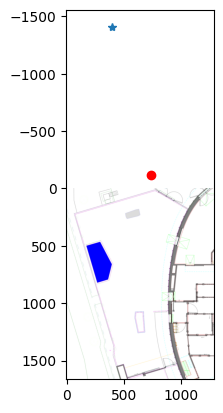

In [182]:
from tqdm import tqdm

camera_in_world = T_world_from_camera[0:3,3].copy()
camera_in_world[2]  = 1
camera_in_submap = T_submap_from_world@camera_in_world
display(camera_in_world)

xs=[]
for u in [width/2]:
# for u in range(0,width,50):
    uv = np.array([[u,height/2,1]]).T
    print(f"{uv=}")
    uvnorm = invK@uv
    print(f"{uvnorm=}")
    uvnorm[2] = -2000
    x  = T_world_from_camera @ np.concatenate([uvnorm,[[1]]],axis=0)
    print(f"{x=}")
    x[2] =1
    s = T_submap_from_world@x[:3]
    print(f"{s=}")
    xs.append(s)
xs = np.asarray(xs)
# print(len(xs[0]))

plt.imshow(im_submap)
plt.plot(xs[:,0],xs[:,1],"o-",color="red")
plt.plot(camera_in_submap[0],camera_in_submap[1],"*")


In [32]:
import json
from pathlib import Path

config_file = Path("../data/config.json")
try:
    with config_file.open() as f:
        config = json.load(f)
except:
    config = {}

if "cameras" not in config:
    config["cameras"] = {}
if camera_name not in config["cameras"]:
    config["cameras"][camera_name] = {}
    camera_config = config["cameras"][camera_name]


camera_config["H_worldFromCamera"] = H_world_from_camera.tolist()
config_json = json.dumps(config,indent=2)
print(config_json)

with config_file.open("w") as f:
    f.write(config_json)

{
  "map": {
    "image": "kkep_floorplan.png",
    "T_world_from_image": [
      [
        0.0282213293,
        0.0,
        -120.756855
      ],
      [
        -0.0,
        -0.028214592,
        103.160262
      ],
      [
        0.0,
        0.0,
        1.0
      ]
    ]
  },
  "cameras": {
    "Kamera 01": {
      "H_worldFromCamera": [
        [
          -0.004340083756349658,
          -0.0498274040212114,
          -59.50719726737088
        ],
        [
          -0.02425379470263873,
          -0.002656007731721079,
          67.83180827340627
        ],
        [
          2.7201908673595802e-05,
          -0.00010492226397889542,
          1.0
        ]
      ]
    }
  }
}


In [78]:
# 468, 437
p = np.array([[680,258,1]]).reshape((3,1))
from_h(H@p)

array([[468.06075567, 437.65881785]])